<a href="https://colab.research.google.com/github/Heulwen31/LandCoverMappingUseSentinel2RandomForest/blob/main/LandCoverMappingUseSentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install earthpy gdal 

#Import library

In [81]:
from glob import glob
import sys
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')
import pandas as pd

from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

#Read data from sentinel 2

In [82]:
file_path = "/content/drive/MyDrive/AI/HCM_30m_ProjectRaster1.tif"

In [83]:
l = []

with rio.open(file_path, 'r') as f:
  for j in range(1,13): 
    l.append(f.read(j))

In [84]:
arr_st = np.stack(l)
print(arr_st.shape)
print(arr_st)

(12, 3006, 2478)
[[[-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  ...
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]]

 [[-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  ...
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]]

 [[-3.403e+38 -3.403e+38 -3.403e+38 ... -3.403e+38 -3.403e+38 -3.403e+38]
  [-3

In [85]:
fill_null = arr_st[0][0][0]
arr_st = np.nan_to_num(arr_st, nan=fill_null)

#Use gdal read band image and convert coordinate to point

In [86]:
from osgeo import osr, ogr, gdal

tif = gdal.Open(file_path)
gt = tif.GetGeoTransform()

# convert coordinates to pixels
def world_to_pixel(geo_matrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

#read data from arr_st to fill 12 band in pandas table 
def read_band_from_tiff(x, y, data):
  a, b = world_to_pixel(gt, x, y)
  ls = []
  for i in range(12):
    ls.append(data[i, b, a])
  return ls
print(read_band_from_tiff(692570.3, 1158673, arr_st))

[0.06324, 0.08784667, 0.10897333, 0.10288667, 0.10225333, 0.06503333, 0.06739333, 0.059266668, 0.05274667, 0.047626667, 0.032353334, 0.028206667]


##Read data from excel


In [87]:
df = pd.read_excel('/content/drive/MyDrive/AI/Data.xlsx')
df

,X,Y,Label,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12
0,692570.3,1158673,Open water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,701976.6,1170650,Open water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,702281.4,1165919,Open water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,692162.8,1169897,Open water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,715599.0,1156236,Open water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17807,692654.4,1162597,Aquarculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17808,698060.8,1172172,Aquarculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17809,695429.4,1155851,Aquarculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17810,702169.6,1171945,Aquarculture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
bands_list = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12']

ndvi = []
ndwi = []
#fill band to pandas 
for i in df.index: 
  l = read_band_from_tiff(df['X'][i], df['Y'][i], arr_st)
  ndvi.append((l[7]-l[4])/(l[7]+l[4]))
  ndwi.append((l[2]-l[7])/(l[2]+l[7]))
  for j in range(12):
    df[bands_list[j]][i] = l[j]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in float_scalars
  if __name__ == '__main__':


In [89]:
df['NDVI'] = ndvi
df['NDWI'] = ndwi
df

,X,Y,Label,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,NDVI,NDWI
0,692570.3,1158673,Open water,0.063240,0.087847,0.108973,0.102887,0.102253,0.065033,0.067393,0.059267,0.052747,0.047627,0.032353,0.028207,-0.266138,0.295451
1,701976.6,1170650,Open water,0.075611,0.080354,0.102391,0.100986,0.101277,0.064606,0.069180,0.056643,0.057229,0.089129,0.030506,0.028677,-0.282639,0.287665
2,702281.4,1165919,Open water,0.085951,0.102891,0.118534,0.113397,0.115391,0.083986,0.085520,0.080703,0.072237,0.078123,0.044883,0.036343,-0.176897,0.189881
3,692162.8,1169897,Open water,0.058618,0.072147,0.100506,0.101659,0.098394,0.050776,0.053206,0.041965,0.035335,0.023771,0.013147,0.011588,-0.402037,0.410900
4,715599.0,1156236,Open water,0.085685,0.086815,0.101430,0.078760,0.074365,0.046935,0.047745,0.041510,0.038555,0.087920,0.025365,0.022780,-0.283538,0.419197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17807,692654.4,1162597,Aquarculture,0.048950,0.061212,0.087725,0.083400,0.119187,0.133800,0.141400,0.135944,0.144613,0.113094,0.105356,0.074256,0.065677,-0.215581
17808,698060.8,1172172,Aquarculture,0.042965,0.059565,0.080206,0.065394,0.106547,0.214547,0.259994,0.267000,0.272994,0.268853,0.120841,0.069453,0.429539,-0.537992
17809,695429.4,1155851,Aquarculture,0.098159,0.076365,0.097247,0.087059,0.106088,0.074641,0.079612,0.066859,0.072135,0.188847,0.063024,0.058100,-0.226829,0.185175
17810,702169.6,1171945,Aquarculture,0.052500,0.064694,0.081883,0.074208,0.095844,0.120214,0.137861,0.125742,0.142844,0.188411,0.100553,0.065439,0.134924,-0.211238


In [90]:
VL = arr_st[0][0][0]
for i in range(100):
  df.loc[len(df.index)] = [0.0, 0.0, 'None', VL, VL, VL, VL, VL, VL, VL, VL, VL, VL, VL, VL, 0.0, 0.0]

In [91]:
df

,X,Y,Label,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,NDVI,NDWI
0,692570.3,1158673.0,Open water,6.324000e-02,8.784667e-02,1.089733e-01,1.028867e-01,1.022533e-01,6.503333e-02,6.739333e-02,5.926667e-02,5.274667e-02,4.762667e-02,3.235333e-02,2.820667e-02,-0.266138,0.295451
1,701976.6,1170650.0,Open water,7.561143e-02,8.035429e-02,1.023914e-01,1.009857e-01,1.012771e-01,6.460571e-02,6.918000e-02,5.664286e-02,5.722857e-02,8.912857e-02,3.050571e-02,2.867714e-02,-0.282639,0.287665
2,702281.4,1165919.0,Open water,8.595143e-02,1.028914e-01,1.185343e-01,1.133971e-01,1.153914e-01,8.398572e-02,8.552000e-02,8.070286e-02,7.223714e-02,7.812285e-02,4.488286e-02,3.634286e-02,-0.176897,0.189881
3,692162.8,1169897.0,Open water,5.861765e-02,7.214706e-02,1.005059e-01,1.016588e-01,9.839412e-02,5.077647e-02,5.320588e-02,4.196471e-02,3.533529e-02,2.377059e-02,1.314706e-02,1.158824e-02,-0.402037,0.410900
4,715599.0,1156236.0,Open water,8.568500e-02,8.681500e-02,1.014300e-01,7.876000e-02,7.436500e-02,4.693500e-02,4.774500e-02,4.151000e-02,3.855500e-02,8.792000e-02,2.536500e-02,2.278000e-02,-0.283538,0.419197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000
17908,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000
17909,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000
17910,0.0,0.0,None,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000,0.000000


In [92]:
train, test = train_test_split(df, test_size=0.2, random_state = 42)

train_set = train[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'NDVI', 'NDWI']].to_numpy()
train_label = train[['Label']].to_numpy()

test_set =  test[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'NDVI', 'NDWI']].to_numpy()
test_label = test[['Label']].to_numpy()
test_set = np.nan_to_num(test_set, nan=0)

In [105]:
clf = RandomForestClassifier(max_depth=512, random_state=42)
test_predict = clf.fit(train_set, train_label.ravel()).predict(test_set)

In [106]:
# dictionary flexible name and number class 
target_names = {'Aquarculture': 0, 'Barren land ': 1,  
                'Crop lands': 2, 'Forest': 3,
                'Grass land': 4, 'None': 5,
                'Open water': 6, 'Residential Land': 7, 
                'Rice paddies': 8, 'Scub/Schrub': 9, 
                'Wetland': 10}

# class name 
class_names = np.unique(test_label)
print(class_names)

# convert label to number 
test_predict_to_number = []
test_label_to_number = []

for i in range(len(test_predict)):
  test_predict_to_number.append(target_names.get(test_predict[i]))
  test_label_to_number.append(target_names.get(test_label[i][0]))
print(test_predict_to_number)
print(test_label_to_number)

['Aquarculture' 'Barren land ' 'Crop lands' 'Forest' 'Grass land' 'None'
 'Open water' 'Residential Land' 'Rice paddies' 'Scub/Schrub' 'Wetland']
[7, 9, 10, 7, 3, 3, 8, 0, 7, 10, 7, 7, 7, 7, 8, 10, 1, 7, 3, 0, 7, 3, 3, 7, 2, 0, 2, 7, 6, 4, 0, 10, 2, 0, 10, 1, 2, 0, 0, 2, 0, 7, 10, 1, 10, 7, 7, 3, 7, 3, 1, 0, 7, 10, 2, 7, 6, 9, 10, 2, 10, 6, 6, 6, 10, 7, 8, 2, 4, 9, 2, 8, 3, 10, 1, 7, 8, 3, 2, 7, 10, 7, 7, 7, 8, 7, 10, 8, 4, 6, 7, 0, 10, 3, 6, 9, 7, 10, 7, 7, 7, 2, 10, 0, 8, 6, 10, 7, 7, 10, 2, 6, 7, 2, 10, 7, 7, 10, 0, 6, 3, 2, 10, 10, 3, 3, 7, 7, 7, 8, 7, 0, 7, 10, 2, 3, 7, 2, 10, 3, 8, 7, 0, 6, 2, 0, 3, 3, 10, 9, 3, 2, 10, 9, 7, 7, 10, 10, 3, 1, 7, 2, 9, 7, 7, 8, 6, 8, 10, 7, 9, 0, 3, 7, 7, 10, 0, 6, 3, 0, 3, 3, 7, 8, 3, 3, 6, 3, 2, 0, 1, 2, 2, 8, 2, 2, 2, 10, 3, 3, 8, 7, 7, 10, 6, 9, 10, 7, 10, 10, 10, 2, 8, 0, 0, 8, 7, 3, 2, 2, 2, 0, 10, 10, 7, 10, 9, 7, 6, 7, 10, 1, 4, 6, 10, 8, 3, 0, 3, 10, 4, 7, 6, 7, 7, 10, 7, 10, 2, 7, 3, 7, 3, 7, 1, 0, 10, 10, 10, 3, 2, 1, 6, 10, 3, 6, 10, 7,

In [107]:
print(classification_report(test_label_to_number, test_predict_to_number, target_names=class_names))

                  precision    recall  f1-score   support

    Aquarculture       0.64      0.67      0.66       332
    Barren land        0.49      0.26      0.34       227
      Crop lands       0.38      0.47      0.42       412
          Forest       0.54      0.57      0.55       341
      Grass land       0.59      0.61      0.60       120
            None       0.95      1.00      0.97        19
      Open water       0.89      0.87      0.88       222
Residential Land       0.68      0.84      0.75       682
    Rice paddies       0.48      0.39      0.43       338
     Scub/Schrub       0.39      0.18      0.25       222
         Wetland       0.88      0.89      0.88       668

        accuracy                           0.64      3583
       macro avg       0.63      0.61      0.61      3583
    weighted avg       0.63      0.64      0.63      3583



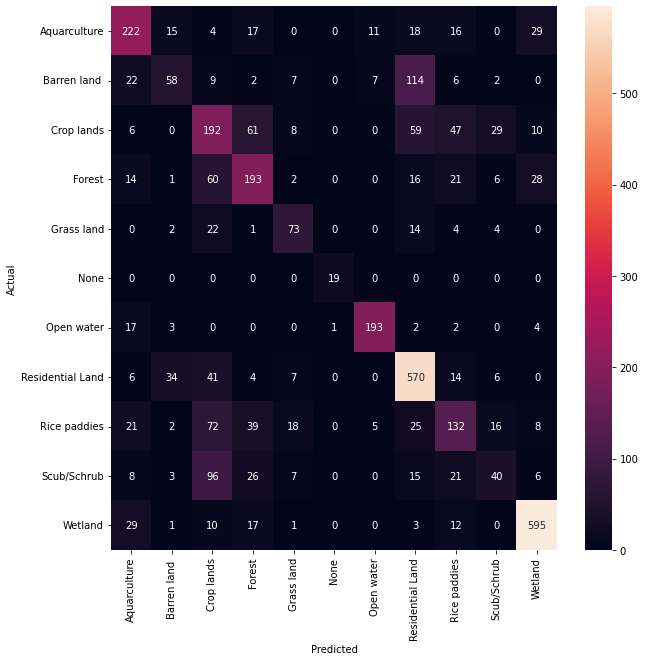

In [108]:
conf_mat = confusion_matrix(test_label_to_number, test_predict_to_number)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [109]:
df['Label'].value_counts()

Residential Land    3378
Wetland             3378
Crop lands          2048
Rice paddies        1689
Forest              1689
Aquarculture        1689
Open water          1126
Barren land         1126
Scub/Schrub         1126
Grass land           563
None                 100
Name: Label, dtype: int64

In [125]:
arr = []

# Create land cover mapping 


In [126]:
for i in range(3006):
  for j in range(2478):
    ls = []
    for k in range(12):
      ls.append(arr_st[k][i][j])
    ls.append((ls[7]-ls[4])/(ls[7] + ls[4]))
    ls.append((ls[2]-ls[7])/(ls[2]+ls[7]))
    arr.append(ls)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in float_scalars
  import sys


In [127]:
arr = np.array(arr)
print(arr.shape)

(7448868, 14)


In [128]:
arr = np.nan_to_num(arr, nan=0)
arr = clf.predict(arr)
# ep.plot_bands(clf.predict(arr).reshape((3006, 2478)), 
#               cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen', 'darkgreen', 'green', 'black', '#CA6F1E', 'navy']))
# plt.show()


In [129]:
for i in range(len(arr)):
  arr[i] = target_names.get(arr[i])
arr = arr.reshape(3006, 2478)

In [130]:
print(arr.shape)

(3006, 2478)


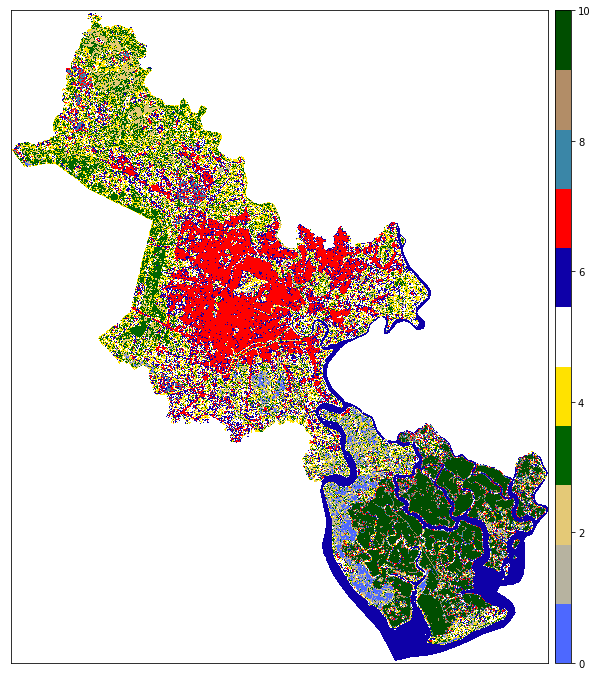

In [131]:
# target_names = {'Aquarculture': 0, 'Barren land ': 1,  
#                 'Crop lands': 2, 'Forest': 3,
#                 'Grass land': 4, 'None': 5,
#                 'Open water': 6, 'Residential Land': 7, 
#                 'Rice paddies': 8, 'Scub/Schrub': 9, 
#                 'Wetland': 10}

ep.plot_bands(arr.astype(float), cmap=ListedColormap(['#4d68ff', '#b7b3a0', 
                                                      '#e4c977', '#006400', 
                                                      '#ffe200', 'white', 
                                                      '#0e00a8', 'red', 
                                                      '#3a86a7', '#b28d67', 
                                                      '#004e00']))
plt.show()